# RL

In [1]:
## first, import the libraries we are going to use

import matplotlib.pyplot as plt
import sys
import numpy as np 
import math
import decimal
from collections import namedtuple
import pypfopt as pyp

import time
import random
import pandas as pd
import seaborn as sns
import json

In [2]:
minute_df_usd_price_est = pd.read_csv('minute_data_mid_usd_est.csv', index_col=0)
cur = ['USD.EUR.SPOT','USD.CAD.SPOT','USD.JPY.SPOT']
minute_df_usd_price_est = minute_df_usd_price_est[cur]
minute_df_usd_price_est = minute_df_usd_price_est.ffill()
minute_df_usd_price_est.index = pd.to_datetime(minute_df_usd_price_est.index)

In [3]:
ret_df = minute_df_usd_price_est.pct_change()
ret_df_bps = ret_df*10000

In [4]:
hour_start = minute_df_usd_price_est.iloc[::60, :]
hour_start_train = hour_start[hour_start.index < pd.Timestamp(2022,5,1)]
hour_start_backtest = hour_start[(hour_start.index >= pd.Timestamp(2022,5,1)) & (hour_start.index < pd.Timestamp(2022,6,1))]
hour_start_test = hour_start[(hour_start.index >= pd.Timestamp(2022,6,1))]

In [5]:
def runif(): 
    """uniform random number generator"""
    return np.random.uniform(0, 1, 1)[0]

In [6]:
def index_list(L): 
    """from a list, build a dictionary which list element to position"""
    return dict(zip(L, [x for x in range(0, len(L))]))

In [7]:
def cov_dif_frob_norm(securities_returns, lookback, interval):
    frob = []
    dates = []
#     for i in range(23*60,len(securities_returns),23*60):
    # at what interval you want to train
    for i in range(interval,len(securities_returns),interval):
        vector = securities_returns[i:i+lookback]
        prior_vector = securities_returns[i-interval:i+lookback-interval]
        M_now = np.cov(vector.T, ddof=0)
        M_prior = np.cov(prior_vector.T, ddof=0)
        M_dif = M_now-M_prior
        frob.append(np.linalg.norm(M_dif))
        dates.append(vector.index[-1])
    frob_df = pd.DataFrame(frob)
    frob_df.index = dates
    return frob_df

In [8]:
frob_full_raw = cov_dif_frob_norm(ret_df_bps,23*60, 60)
frob_full = round(frob_full_raw*5)
frob_full[frob_full>3]=3

In [9]:
frob_full

,0
2022-01-03 18:59:00,NaN
2022-01-03 19:59:00,0.0
2022-01-03 20:59:00,0.0
2022-01-03 21:59:00,0.0
2022-01-03 22:59:00,0.0
...,...
2022-06-30 16:59:00,3.0
2022-06-30 16:59:00,3.0
2022-06-30 16:59:00,2.0
2022-06-30 16:59:00,2.0


In [10]:
returns_dict = {}
frob_hours ={}
frob_train_hours ={}
frob_backtest_hours = {}

for p in range(0,24, 3):
    returns_dict[p] = ret_df_bps[ret_df_bps.index.hour.isin([p,p+1,p+2])]
    frob_hour = cov_dif_frob_norm(returns_dict[p],5*3*60, 60)
    frob_hour = round(frob_hour*5)
    frob_hour[frob_hour>3]=3
    frob_hours[p] = frob_hour
frob_hours = pd.concat(frob_hours ,axis=0).droplevel(level=0,axis=0).sort_index()

In [11]:
frob_full

,0
2022-01-03 18:59:00,NaN
2022-01-03 19:59:00,0.0
2022-01-03 20:59:00,0.0
2022-01-03 21:59:00,0.0
2022-01-03 22:59:00,0.0
...,...
2022-06-30 16:59:00,3.0
2022-06-30 16:59:00,3.0
2022-06-30 16:59:00,2.0
2022-06-30 16:59:00,2.0


In [12]:
frob_hours

,0
2022-01-09 18:59:00,NaN
2022-01-09 19:59:00,0.0
2022-01-09 20:59:00,1.0
2022-01-09 21:59:00,0.0
2022-01-09 22:59:00,0.0
...,...
2022-06-30 16:59:00,2.0
2022-06-30 16:59:00,0.0
2022-06-30 16:59:00,3.0
2022-06-30 16:59:00,3.0


In [13]:
frob_full = frob_full[~frob_full.index.duplicated(keep='first')]
frob_full.columns = ['frob_full']
states = frob_hours.join(frob_full)
states = states.fillna(method='bfill')
states['segment'] = states.index.hour//4
states.columns =['frob_seg', 'frob_full', 'segment']

In [14]:
states

,frob_seg,frob_full,segment
2022-01-09 18:59:00,0.0,0.0,4
2022-01-09 19:59:00,0.0,0.0,4
2022-01-09 20:59:00,1.0,0.0,5
2022-01-09 21:59:00,0.0,0.0,5
2022-01-09 22:59:00,0.0,0.0,5
...,...,...,...
2022-06-30 16:59:00,2.0,0.0,4
2022-06-30 16:59:00,0.0,0.0,4
2022-06-30 16:59:00,3.0,0.0,4
2022-06-30 16:59:00,3.0,0.0,4


In [15]:
states_train= states[(states.index >= pd.Timestamp(2022,2,1)) & (states.index < pd.Timestamp(2022,5,1))]
states_test = states[(states.index >= pd.Timestamp(2022,5,1)) & (states.index < pd.Timestamp(2022,6,1))]

In [16]:
Action = namedtuple('Action', ['weight'])
State = namedtuple('State', ['frobenius_norm_seg','frobenius_norm_full','segment'])

In [31]:
weightOptions = [(1/3,1/3,1/3),(1/2,1/4,1/4),(1/4,1/2,1/4),(1/4,1/4,1/2)]
#weightOptions = [(1/3,1/3,1/3),(1/10,1/10,8/10),(1/10,8/10,1/10),(8/10,1/10,1/10)]
# weightOptions = [(1,0,0),(0,1,0),(0,0,1)]
# weightOptions = [(1/3,1/3,1/3),(1,0,0),(0,1,0),(0,0,1)]

actionSpace = [Action(w) for w in weightOptions]

full_range = np.arange(frob_full.min()[0],frob_full.max()[0]+1,1)
seg_range = np.arange(frob_hours.min()[0],frob_hours.max()[0]+1,1)
stateSpace = [State(h,round(f,0),round(p,0)) for h in seg_range for f in full_range for p in np.arange(6)]

In [32]:
len(stateSpace)

96

In [33]:
stateSpace

[State(frobenius_norm_seg=0.0, frobenius_norm_full=0.0, segment=0),
 State(frobenius_norm_seg=0.0, frobenius_norm_full=0.0, segment=1),
 State(frobenius_norm_seg=0.0, frobenius_norm_full=0.0, segment=2),
 State(frobenius_norm_seg=0.0, frobenius_norm_full=0.0, segment=3),
 State(frobenius_norm_seg=0.0, frobenius_norm_full=0.0, segment=4),
 State(frobenius_norm_seg=0.0, frobenius_norm_full=0.0, segment=5),
 State(frobenius_norm_seg=0.0, frobenius_norm_full=1.0, segment=0),
 State(frobenius_norm_seg=0.0, frobenius_norm_full=1.0, segment=1),
 State(frobenius_norm_seg=0.0, frobenius_norm_full=1.0, segment=2),
 State(frobenius_norm_seg=0.0, frobenius_norm_full=1.0, segment=3),
 State(frobenius_norm_seg=0.0, frobenius_norm_full=1.0, segment=4),
 State(frobenius_norm_seg=0.0, frobenius_norm_full=1.0, segment=5),
 State(frobenius_norm_seg=0.0, frobenius_norm_full=2.0, segment=0),
 State(frobenius_norm_seg=0.0, frobenius_norm_full=2.0, segment=1),
 State(frobenius_norm_seg=0.0, frobenius_norm_fu

In [34]:
alpha = 0.01 ## learning rate

class TabularQLearner:
    def __init__(self, act_space, state_space, eps=0.1):
        self.actions = act_space
        self.states = state_space
        self.lookup = index_list(state_space)
        self.Q = np.zeros((len(self.states), len(self.actions)))
        self.epsilon = eps
        self.action_lookup = index_list(act_space)
        self.zero_trade = self.action_lookup[act_space[0]]

    def __greedy_action_index(self, state_index):
        """calculate the integer for indexing into self.Q or self.actions of the greedy action"""
        q = self.Q[state_index]
        if not np.any(q):
            return self.zero_trade
        else:
            return np.argmax(q)

    def greedy_action(self, state):
        """calculate the actual greedy action, not just its index"""
        return self.actions[self.__greedy_action_index(self.lookup[state])]

    def maxQ(self, state):
        return max(self.Q[self.lookup[state]])

    def train(self, states):
        for h in range(len(states)-1):
            curr = State(states.iloc[h,0],states.iloc[h,1],states.iloc[h,2])
            i = self.lookup[curr]

            rand = runif()
            # with probability epsilon, select action randomly from amongst all available actions with equal probability
            if rand <= self.epsilon:
                a = random.choice(self.actions)
            else:
                a = self.greedy_action(curr)
            j = self.action_lookup[a]
            
            # for reward calculation
            train_df = ret_df[(ret_df.index <= hour_start.index[h+1]) & (ret_df.index > hour_start.index[h])]
            
            train_performance = list(a.weight)*train_df
            train_port = train_performance.sum(axis=1)
            reward = -train_port.var()
            
            self.Q[i,j] = self.Q[i,j] + alpha * (reward - self.Q[i,j])

In [35]:
learner = TabularQLearner(actionSpace, stateSpace, eps=0.1)
for x in range(10):
    learner.train(states)

In [36]:
learner.Q

array([[-5.17665060e-09, -5.26843796e-09, -5.16396206e-09,
        -5.87140171e-09],
       [-4.20668502e-09, -4.28507534e-09, -4.28208073e-09,
        -4.36426642e-09],
       [-2.76475291e-09, -2.94831286e-09, -2.83400320e-09,
        -2.80484493e-09],
       [-1.93258484e-08, -1.93213394e-08, -1.95274903e-08,
        -1.87631608e-08],
       [-9.05901348e-09, -9.18308947e-09, -8.94077761e-09,
        -9.00282153e-09],
       [-8.63089211e-09, -7.38062595e-09, -8.09725440e-09,
        -7.44967201e-09],
       [-2.79799675e-09, -2.82890744e-09, -2.78119774e-09,
        -3.02812341e-09],
       [-3.07215881e-09, -3.08640253e-09, -3.08788355e-09,
        -3.29402695e-09],
       [-2.04182277e-09, -2.05772274e-09, -2.02742297e-09,
        -2.08068877e-09],
       [-7.49669858e-09, -7.38471223e-09, -7.25343010e-09,
        -7.19106776e-09],
       [-4.62562322e-09, -4.45547996e-09, -4.54195921e-09,
        -4.52622840e-09],
       [-2.15574418e-09, -2.20952237e-09, -2.15592078e-09,
      

In [37]:
qfunction = pd.DataFrame(columns=['seg', 'frob_seg', 'frob_full', 'optimal_weight_eur', 'optimal_weight_cad', 'optimal_weight_jpy'])
for s in stateSpace:
    optimal_weight = learner.greedy_action(s).weight
    qfunction = qfunction.append({'seg': int(s.segment),'frob_seg': int(s.frobenius_norm_seg), 'frob_full' : int(s.frobenius_norm_full), 'optimal_weight_eur': optimal_weight[0], 'optimal_weight_cad': optimal_weight[1], 'optimal_weight_jpy': optimal_weight[2]}, ignore_index = True)


C:\Users\evank\AppData\Local\Temp\ipykernel_15860\828091224.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qfunction = qfunction.append({'seg': int(s.segment),'frob_seg': int(s.frobenius_norm_seg), 'frob_full' : int(s.frobenius_norm_full), 'optimal_weight_eur': optimal_weight[0], 'optimal_weight_cad': optimal_weight[1], 'optimal_weight_jpy': optimal_weight[2]}, ignore_index = True)
C:\Users\evank\AppData\Local\Temp\ipykernel_15860\828091224.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qfunction = qfunction.append({'seg': int(s.segment),'frob_seg': int(s.frobenius_norm_seg), 'frob_full' : int(s.frobenius_norm_full), 'optimal_weight_eur': optimal_weight[0], 'optimal_weight_cad': optimal_weight[1], 'optimal_weight_jpy': optimal_weight[2]}, ignore_index = True)
C:\Users\evank\AppData\Local\Temp\ipykerne

In [38]:
qfunction

,seg,frob_seg,frob_full,optimal_weight_eur,optimal_weight_cad,optimal_weight_jpy
0,0.0,0.0,0.0,0.25,0.5,0.25
1,1.0,0.0,0.0,0.333333,0.333333,0.333333
2,2.0,0.0,0.0,0.333333,0.333333,0.333333
3,3.0,0.0,0.0,0.25,0.25,0.5
4,4.0,0.0,0.0,0.25,0.5,0.25
...,...,...,...,...,...,...
91,1.0,3.0,3.0,0.25,0.25,0.5
92,2.0,3.0,3.0,0.25,0.25,0.5
93,3.0,3.0,3.0,0.333333,0.333333,0.333333
94,4.0,3.0,3.0,0.25,0.25,0.5


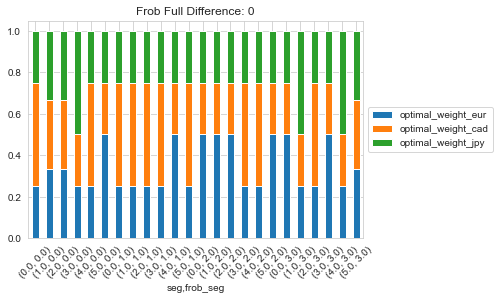

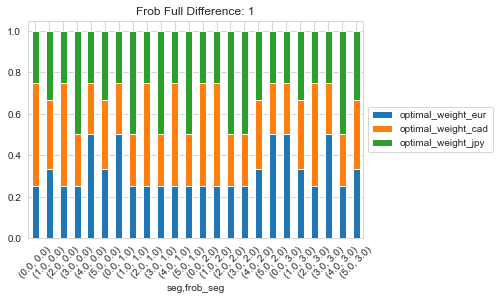

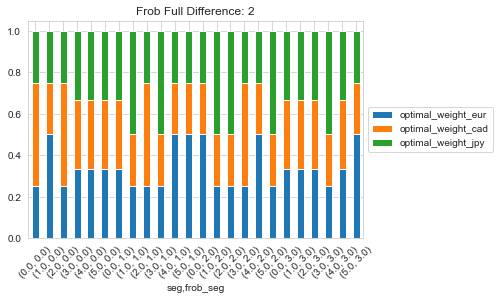

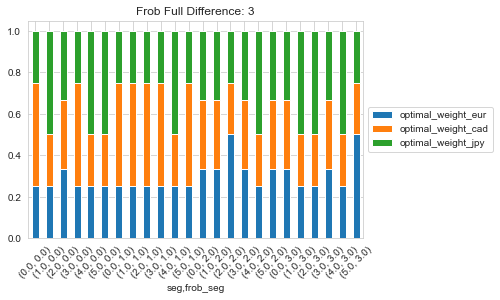

In [39]:
for x in range(4):
    seg_df = qfunction[qfunction['frob_full']==x]
    seg_df =seg_df.drop(columns='frob_full')
    ax = seg_df.set_index(['seg','frob_seg']).plot(kind='bar',stacked=True)
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=45)
    plt.title('Frob Full Difference: '+ str(x))

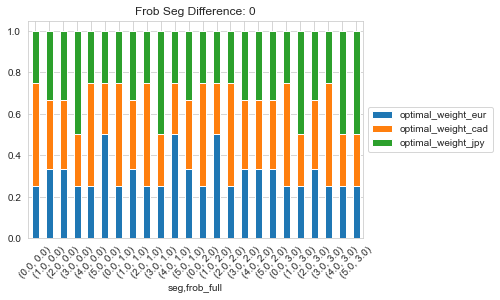

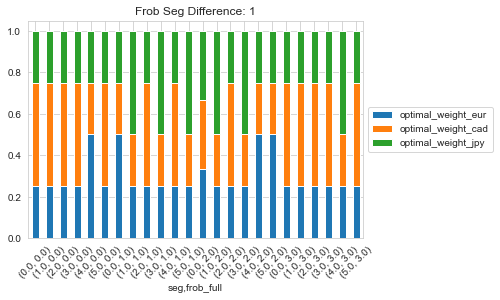

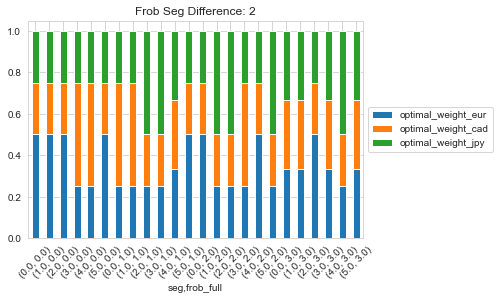

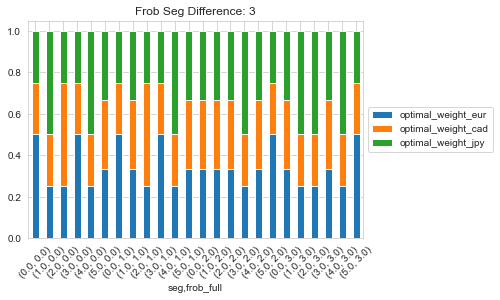

In [40]:
for x in range(4):
    seg_df = qfunction[qfunction['frob_seg']==x]
    seg_df =seg_df.drop(columns='frob_seg')
    ax = seg_df.set_index(['seg','frob_full']).plot(kind='bar',stacked=True)
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=45)
    plt.title('Frob Seg Difference: '+ str(x))

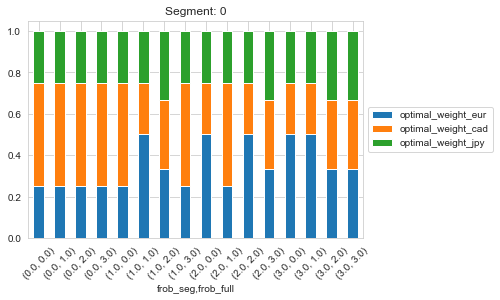

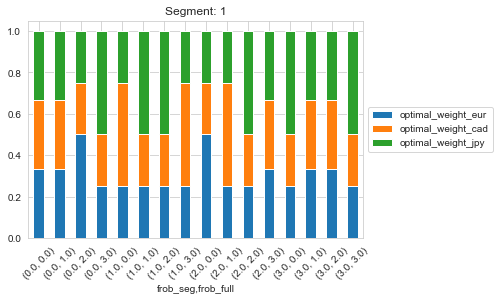

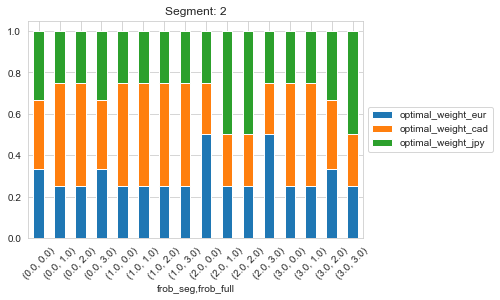

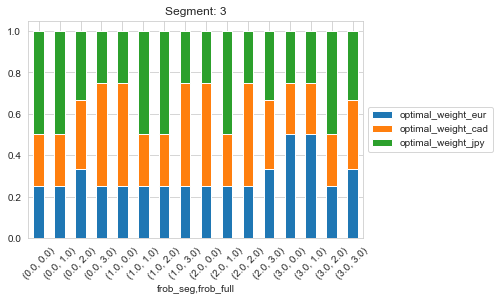

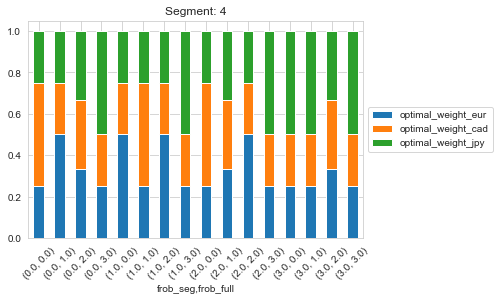

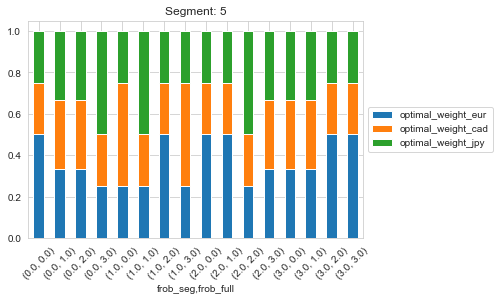

In [41]:
for x in range(6):
    seg_df = qfunction[qfunction['seg']==x]
    seg_df =seg_df.drop(columns='seg')
    ax = seg_df.set_index(['frob_seg','frob_full']).plot(kind='bar',stacked=True)
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=45)
    plt.title('Segment: '+ str(x))

In [43]:
states

,frob_seg,frob_full,segment
2022-01-09 18:59:00,0.0,0.0,4
2022-01-09 19:59:00,0.0,0.0,4
2022-01-09 20:59:00,1.0,0.0,5
2022-01-09 21:59:00,0.0,0.0,5
2022-01-09 22:59:00,0.0,0.0,5
...,...,...,...
2022-06-30 16:59:00,2.0,0.0,4
2022-06-30 16:59:00,0.0,0.0,4
2022-06-30 16:59:00,3.0,0.0,4
2022-06-30 16:59:00,3.0,0.0,4


In [46]:
test_return = pd.DataFrame()
states = states.loc['2022-05-30':]
for h in range(len(states)-1):
    curr = State(states.iloc[h,0],states.iloc[h,1],states.iloc[h,2])
    optimal_weight = learner.greedy_action(curr).weight
    
    test_df = ret_df[(ret_df.index <= states.index[h+1]) & (ret_df.index > states.index[h])]

    test_performance = list(optimal_weight)*test_df
    test_port = test_performance.sum(axis=1)
    test_return = test_return.append(pd.DataFrame(test_port))

test_return.std()*np.sqrt(23*60*252)

C:\Users\evank\AppData\Local\Temp\ipykernel_15860\3420226411.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_return = test_return.append(pd.DataFrame(test_port))
C:\Users\evank\AppData\Local\Temp\ipykernel_15860\3420226411.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_return = test_return.append(pd.DataFrame(test_port))
C:\Users\evank\AppData\Local\Temp\ipykernel_15860\3420226411.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_return = test_return.append(pd.DataFrame(test_port))
C:\Users\evank\AppData\Local\Temp\ipykernel_15860\3420226411.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_return = 

0    0.078197
dtype: float64

In [42]:
train_return = pd.DataFrame()
for h in range(len(states)-1):
    curr = State(states.iloc[h,0],states.iloc[h,1],states.iloc[h,2])
    optimal_weight = learner.greedy_action(curr).weight

    test_df = ret_df[(ret_df.index <= states.index[h+1]) & (ret_df.index > states.index[h])]

    test_performance = list(optimal_weight)*test_df
    test_port = test_performance.sum(axis=1)
    train_return = train_return.append(pd.DataFrame(test_port))

train_return.std()*np.sqrt(23*60*252)